In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

C:\Users\Alvertos\Anaconda3\envs\keras\lib\site-packages\PIL\Image.py:116: RuntimeWarning: The _imaging extension was built for another version of Pillow or PIL:
Core version: 5.3.0
Pillow version: 5.4.1
  warnings.warn(str(v), RuntimeWarning)


In [2]:
#Importing dataset
main_dataset = pd.read_csv("AAPL.csv")
main_dataset_1 = main_dataset.drop("Date",1)
print(main_dataset_1.head(10))

        Open       High        Low      Close  Adj Close     Volume
0  75.701431  77.500000  75.697144  76.532860  65.135979   94623200
1  76.888573  78.104286  76.808571  78.055717  66.432060   83140400
2  79.074287  80.028572  78.808571  79.622856  67.765808   97909700
3  79.271431  79.550003  78.811432  79.178574  67.387703   57319500
4  78.782860  78.867142  77.128571  77.238571  65.736603  106684900
5  77.284286  78.581429  77.202858  78.438568  66.757919   82131700
6  78.701431  79.612854  78.258568  78.787140  67.054565   94996300
7  78.562859  79.500000  77.830002  79.454285  67.622375  100809800
8  79.142860  79.374283  77.821426  78.010002  66.393143  107338700
9  78.581429  79.257141  77.964287  78.642860  66.931786  138719700


In [3]:
columns_names=list(main_dataset_1.columns.values)
print(columns_names)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [4]:
#split data to train and testing we will use the last 10% of our dataset as testing
main_dataset_1_values = main_dataset_1.values
train_size = int(len(main_dataset_1_values) * 0.90) 
test_size = len(main_dataset_1_values) - train_size
training_dataset, validation_dataset = main_dataset_1_values[0:train_size, :], main_dataset_1_values[train_size:len(main_dataset_1_values), :]

In [5]:
#Normalize dataset
from sklearn import preprocessing
taget_colum=training_dataset[:,0]
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
training_dataset_scaled = min_max_scaler.fit_transform(training_dataset)
min_Max_scaler_target=preprocessing.MinMaxScaler(feature_range = (0,1))
taget_colum=taget_colum.reshape(-1,1)
training_taret = min_Max_scaler_target.fit_transform(taget_colum)

C:\Users\Alvertos\Anaconda3\envs\keras\lib\site-packages\PIL\Image.py:116: RuntimeWarning: The _imaging extension was built for another version of Pillow or PIL:
Core version: 5.3.0
Pillow version: 5.4.1
  warnings.warn(str(v), RuntimeWarning)


In [6]:
sequence_lenght = 30 # we are looking a month back
future_period_target =7  # we want to predict 7 days in to the future
def sequential_data(dataset):
    data_X_values, data_Y_values = [], []
    for i in range(len(dataset) - sequence_lenght):
        a = dataset[i:(i + sequence_lenght),:]
        data_X_values.append(a)
        data_Y_values.append(dataset[i + future_period_target, 0])
    return np.array(data_X_values), np.array(data_Y_values)

In [7]:
sequence_lenght = 30 # we are looking a month back
future_period_target =7 # we want to predict 7 days in to the future
def sequential_data_2(dataset):
    data_X_values, data_Y_values = [], []
    for i in range(sequence_lenght,len(dataset) - future_period_target):
        a = dataset[i-sequence_lenght:i,:]
        data_X_values.append(a)
        data_Y_values.append(dataset[i + future_period_target, 0])
    return np.array(data_X_values), np.array(data_Y_values)

In [8]:
train_X, train_Y = sequential_data(training_dataset_scaled)  #using the second function

In [9]:
train_X.shape

(1103, 30, 6)

In [10]:
def generate_next_batch(data_features,data_labels,batch_number=32):
    index=np.arange(0,len(data_features))
    np.random.shuffle(index)
    index=index[:batch_number]
    data_features_shuffle=[data_features[i] for i in index]
    data_labels_shuffle=[data_labels[i] for i in index]
    
    return np.asarray(data_features_shuffle),np.asarray(data_labels_shuffle)

In [11]:
import tensorflow as tf
tf.reset_default_graph()

C:\Users\Alvertos\Anaconda3\envs\keras\lib\site-packages\PIL\Image.py:116: RuntimeWarning: The _imaging extension was built for another version of Pillow or PIL:
Core version: 5.3.0
Pillow version: 5.4.1
  warnings.warn(str(v), RuntimeWarning)
C:\Users\Alvertos\Anaconda3\envs\keras\lib\site-packages\PIL\Image.py:116: RuntimeWarning: The _imaging extension was built for another version of Pillow or PIL:
Core version: 5.3.0
Pillow version: 5.4.1
  warnings.warn(str(v), RuntimeWarning)


In [12]:
num_of_inputs=6
#sequence_lenght
num_of_neurons=100
num_of_outputs=1
num_of_inputs_2=30
learning_rate=0.01
num_of_iterations=100
batch_number=1000
batches = len(train_X)//batch_number

In [13]:
X=tf.placeholder(tf.float32,[None,sequence_lenght,num_of_inputs])
Y=tf.placeholder(tf.float32,[None,1])

In [14]:
cell=tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=num_of_neurons,activation=tf.nn.relu),output_size=num_of_outputs)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [15]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)
#outputs = tf.squeeze(tf.transpose (outputs, [0, 2, 1])[:,:,5])
#outputs = tf.squeeze(tf.transpose (outputs, [0, 2, 1]))
#outputs=outputs[:,:1]
outputs=outputs[:, -1, :] #tp get a last output of a dinamic RNN

In [16]:
loss=tf.reduce_mean(tf.square(outputs-Y))

In [17]:
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [18]:
init= tf.global_variables_initializer()

In [19]:
saver=tf.train.Saver()

In [20]:
gpu_usage_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [21]:


config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

In [22]:
with tf.Session(config=config) as sess:
    sess.run(init)
    
    for epoch in range(num_of_iterations):
        for batch in range(batches):
            X_batch_np,Y_batch_np=generate_next_batch(train_X,train_Y,batch_number)
            X_batch=np.reshape(X_batch_np, (X_batch_np.shape[0], sequence_lenght, 6))
            Y_batch=Y_batch_np[:, None]
            sess.run(train,feed_dict={X:X_batch,Y:Y_batch})
        
        if epoch%10==0:
            mse= loss.eval(feed_dict={X:X_batch,Y:Y_batch})
            print("epoch :",epoch,"\tmse",mse)
    #save model
    saver.save(sess,"./tensorlfow_model")

epoch : 0 	mse 0.03007233
epoch : 10 	mse 0.0043990393
epoch : 20 	mse 0.0038154498
epoch : 30 	mse 0.0031834508
epoch : 40 	mse 0.003150161
epoch : 50 	mse 0.0029332268
epoch : 60 	mse 0.0027312282
epoch : 70 	mse 0.0026350264
epoch : 80 	mse 0.0024193923
epoch : 90 	mse 0.0021539938


In [23]:
#concatinating
validation_dataset_scaled = min_max_scaler.transform(validation_dataset)
training_part=training_dataset_scaled[-sequence_lenght:]
new_validation_scaled=np.concatenate((training_part,validation_dataset_scaled),axis=0)#concatenate verticaly
validation_X ,validation_y = sequential_data(new_validation_scaled)
#Test
with tf.Session(config=config) as sess:
    saver.restore(sess,"./tensorlfow_model")
    X_batch=validation_X
    Y_pred=sess.run(outputs,feed_dict={X:X_batch})

INFO:tensorflow:Restoring parameters from ./tensorlfow_model


In [24]:
predicted_stock_price=Y_pred.reshape(-1,1)
predicted_stock_price = min_Max_scaler_target.inverse_transform(predicted_stock_price)

In [25]:
real_stock_price=validation_dataset[:,0]
real_stock_price=real_stock_price.reshape(-1,1)
real_stock_price_scaled = min_Max_scaler_target.inverse_transform(predicted_stock_price)

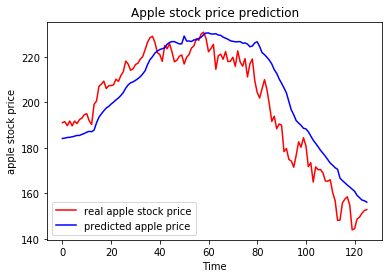

In [26]:
plt.plot(real_stock_price , color= 'red',label="real apple stock price")
plt.plot(predicted_stock_price, color= "blue", label="predicted apple price")
plt.title("Apple stock price prediction")
plt.xlabel("Time")
plt.ylabel("apple stock price")
plt.legend()
plt.show()